In [1]:
from Bio import SeqIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bisect import bisect
import tools

from tqdm.notebook import tqdm

np.random.seed(42)

Файл 'chromosome1.fasta' содержит **последовательность нуклеотидов** первой хромосомы человека

In [2]:
sequence_data = 'chromosome1.fasta'
with open(sequence_data) as file:
    fasta_sequences = SeqIO.parse(file, 'fasta')
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)

Импорт данных 

In [3]:
cds = pd.read_csv('data/cds.csv')
exons = pd.read_csv('data/exons.csv')

In [4]:
exons.head()

,Seqid,Source,Type,Start,End,Score,Strand,Phase
0,NC_000001.11,BestRefSeq,exon,11874,12227,NaN,+,NaN
1,NC_000001.11,BestRefSeq,exon,12613,12721,NaN,+,NaN
2,NC_000001.11,BestRefSeq,exon,13221,14409,NaN,+,NaN
3,NC_000001.11,BestRefSeq,exon,30366,30503,NaN,+,NaN
4,NC_000001.11,BestRefSeq,exon,30438,30458,NaN,+,NaN


In [5]:
cds.head()

,Seqid,Source,Type,Start,End,Score,Strand,Phase
0,NC_000001.11,BestRefSeq,CDS,65565,65573,NaN,+,0
1,NC_000001.11,BestRefSeq,CDS,69037,70008,NaN,+,0
2,NC_000001.11,BestRefSeq,CDS,924432,924948,NaN,+,0
3,NC_000001.11,BestRefSeq,CDS,925922,926013,NaN,+,2
4,NC_000001.11,BestRefSeq,CDS,930155,930336,NaN,+,0


Выделение границ экзонов и кодирующих последовательностей

In [6]:
cds_starts = tools.get_values(cds['Start'])
cds_ends = tools.get_values(cds['End'])

exons_starts = tools.get_values(exons['Start'])
exons_ends = tools.get_values(exons['End'])

Из всех cds нас интересуют начальные (начинаются с **ATG**) и конечные (кончаются на **TAA, TAG, TGA**)

In [7]:
cds_starts_new = []
cds_ends_new = []
    
for start, end in zip(cds_starts, cds_ends):
    
    if (sequence[start-1:start+2] in ['ATG']): 
        cds_starts_new.append(start)
    if (sequence[end-3:end] in ['TAA', 'TAG', 'TGA']):  
        cds_ends_new.append(end)

Чтобы определить последовательность перед cds, необходимо локализовать **ближайший слева** экзон  
Для последовательности после cds - **ближайший справа**

In [8]:
seq_before_cds_location = []
for cds_start in cds_starts_new:
    p = bisect(exons_starts, cds_start)
    seq_before_cds_location.append((exons_starts[p-1], cds_start))
seq_before_cds_location = np.array(seq_before_cds_location)

seq_after_cds_location = []
for cds_end in cds_ends_new:
    p = bisect(exons_ends, cds_end)
    seq_after_cds_location.append((cds_end, exons_ends[p]))
seq_after_cds_location = np.array(seq_after_cds_location)

На выходе имеем массив с границами **участков перед начальной cds** внутри соответствующих экзонов

In [9]:
seq_before_cds_location

array([[    65520,     65565],
       [   923923,    924432],
       [   925922,    925942],
       ...,
       [237678048, 237678048],
       [239907433, 239907452],
       [240091883, 240092110]], dtype=int64)

И массив с границами **участков после последней cds** внутри соответствующих экзонов

In [10]:
seq_after_cds_location

array([[    70008,     71585],
       [   944153,    944574],
       [   965191,    965719],
       ...,
       [248522597, 248527337],
       [248848633, 248849517],
       [248918363, 248919146]], dtype=int64)

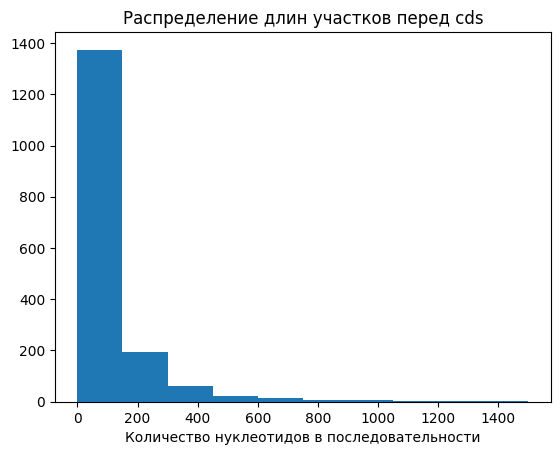

In [11]:
plt.title('Распределение длин участков перед cds')
plt.xlabel('Количество нуклеотидов в последовательности')
plt.hist(np.diff(seq_before_cds_location), range=(0, 1500));

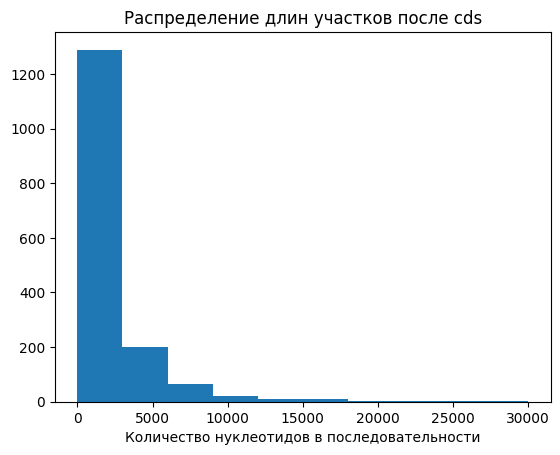

In [12]:
plt.title('Распределение длин участков после cds')
plt.xlabel('Количество нуклеотидов в последовательности')
plt.hist(np.diff(seq_after_cds_location), range=(0, 30000));

Ограничим длины последовательностей , чтобы рассчитываемые далее статистики были **релевантны**

In [13]:
start_cds_location_data = tools.limit(seq_before_cds_location, min_length=50, max_length=1500)
start_cds_location_data.to_csv('data/start_cds_location.csv', index=False)

end_cds_location_data = tools.limit(seq_after_cds_location, min_length=100, max_length=10000)
end_cds_location_data.to_csv('data/end_cds_location.csv', index=False)

In [14]:
start_cds_location_data.head()

,start,end
0,923922,924431
1,960583,960693
2,1013496,1013573
3,1020119,1020172
4,1033992,1034555


In [15]:
end_cds_location_data.head()

,start,end
0,70007,71584
1,944152,944573
2,965190,965718
3,974574,975864
4,1053976,1054550


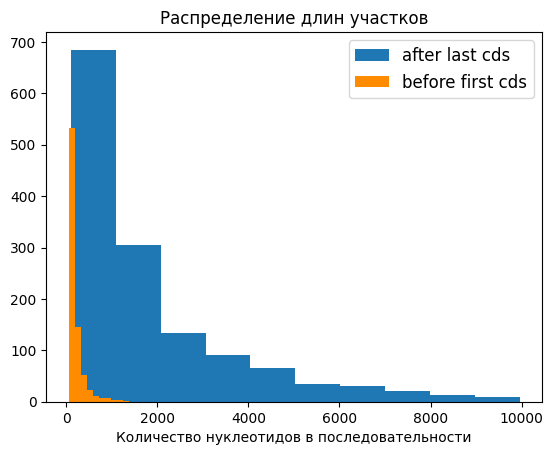

In [16]:
plt.title('Распределение длин участков')
plt.xlabel('Количество нуклеотидов в последовательности')
plt.hist(np.diff(end_cds_location_data), label='after last cds');
plt.hist(np.diff(start_cds_location_data), label='before first cds', color='darkorange');
plt.legend(fontsize='large')

Используя список границ областей интереса, вырежем эти области из исходной последовательности

In [17]:
seq_before_cds = tools.get_sequence(start_cds_location_data, sequence)
seq_after_cds = tools.get_sequence(end_cds_location_data, sequence)

In [18]:
len(seq_before_cds), len(seq_after_cds)

(789, 1387)

Далее необходимо создать аналогичную **выборку для класса 0**, то есть последовательностей, которые **не расположены** перед cds  
Для этого выбираем случайный нуклеотид в цепочке и вырезаем последовательность **длинной L**  
**Число L** определяется из **экспоненциального распределения**, близкого к распределению длин искомых последовательностей  

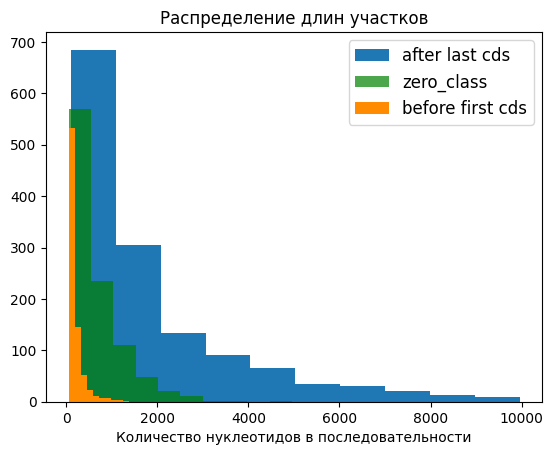

In [19]:
plt.title('Распределение длин участков')
plt.xlabel('Количество нуклеотидов в последовательности')
plt.hist(np.diff(end_cds_location_data), label='after last cds');
plt.hist(np.random.exponential(scale=600.0, size=1000)+50, label='zero_class', alpha=0.7, color='green') #L distribution
plt.hist(np.diff(start_cds_location_data), label='before first cds', color='darkorange');
plt.legend(fontsize='large')

Дополнительно мы убеждаемся, что выбранные последовательности класса 0 **не пересекаются** с границами последовательностей класса 1

In [20]:
n = 8000
seq_zero_location = []
for sample in range(n):
    b = np.random.randint(1e4, 2e8)
    L = int(np.random.exponential(scale=600.0)+50)
    bounds = (b, b+L)
    
    flag = tools.check_intersection(bounds, start_cds_location_data, end_cds_location_data)
    
    if flag:
        seq_zero_location.append(bounds)        

Ниже можно увидеть, сколько примеров класса 0 пересекались с примерами класса 1 и **были исключены**

In [21]:
print(f'Количество исключенных примеров: {n - len(seq_zero_location)}')

Количество исключенных примеров: 112


Дополнительно необходимо **исключить взаимные пересечения** примеров класса 0, чтобы **избежать утечки данных** при разбиении датасета

In [22]:
seq_zero_location_new = tools.check_self_intersection(seq_zero_location)

100%|██████████| 7888/7888 [00:38<00:00, 204.90it/s] 


In [23]:
print(f'Общее количество исключенных примеров: {n - len(seq_zero_location_new)}')

Общее количество исключенных примеров: 285


Используя полученные **границы последовательностей** класса 0, вырезаем их из исходной последовательности

In [24]:
seq_zero = tools.get_sequence(seq_zero_location, sequence)

По полученным кусочкам последовательности рассчитываем признаки используя функцию **calculate_kmer_features**

In [25]:
start_data = tools.calculate_features(seq_before_cds)
end_data = tools.calculate_features(seq_after_cds)
zero_data = tools.calculate_features(seq_zero)

In [26]:
start_data.head()

,A,T,G,C,AT,GC,GA,GT,GG,CG,...,GAC,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG
0,0.082616,0.081422,0.210323,0.188503,0.014111,0.119088,0.055010,0.032336,0.108594,0.115360,...,0.026727,0.077779,0.003623,0.011733,0.006557,0.032336,0.016389,0.070187,0.024772,0.056468
1,0.108048,0.088818,0.189905,0.189905,0.013003,0.103477,0.060316,0.060316,0.066524,0.112478,...,0.013003,0.039512,0.000000,0.031580,0.013003,0.013003,0.022881,0.053784,0.039512,0.039512
2,0.136355,0.107077,0.169011,0.184400,0.017491,0.107077,0.052026,0.041811,0.061423,0.041811,...,0.000000,0.052026,0.017491,0.017491,0.017491,0.017491,0.030497,0.030497,0.030497,0.000000
3,0.024356,0.104104,0.167360,0.233368,0.000000,0.139359,0.000000,0.041956,0.041956,0.139359,...,0.000000,0.041956,0.000000,0.000000,0.000000,0.000000,0.000000,0.057005,0.000000,0.000000
4,0.099628,0.100578,0.186891,0.197117,0.015095,0.101522,0.062778,0.020999,0.084565,0.081348,...,0.022858,0.045398,0.000000,0.024672,0.010794,0.037939,0.015095,0.029880,0.037939,0.043948


In [27]:
end_data.head()

,A,T,G,C,AT,GC,GA,GT,GG,CG,...,GAC,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG
0,0.192964,0.173143,0.119543,0.111952,0.090100,0.028510,0.059276,0.049778,0.032095,0.005459,...,0.011416,0.008131,0.017386,0.012200,0.029721,0.019478,0.020161,0.000000,0.015952,0.009806
1,0.156318,0.132014,0.169294,0.158856,0.035617,0.070184,0.056827,0.043809,0.079381,0.033460,...,0.021807,0.024274,0.004296,0.024274,0.021807,0.031252,0.021807,0.004296,0.021807,0.028989
2,0.118410,0.154121,0.161416,0.173673,0.041230,0.069250,0.038011,0.061495,0.062820,0.045883,...,0.015811,0.023918,0.003489,0.027659,0.006317,0.021978,0.025810,0.017932,0.021978,0.034685
3,0.143987,0.116651,0.174323,0.171919,0.022851,0.068534,0.074116,0.048353,0.070080,0.029725,...,0.014367,0.028246,0.004176,0.024430,0.024430,0.028988,0.021238,0.007539,0.045260,0.035409
4,0.125241,0.121340,0.183006,0.170053,0.029066,0.081468,0.065968,0.048346,0.080418,0.035404,...,0.012619,0.039897,0.003224,0.030693,0.022225,0.033860,0.023991,0.008238,0.038422,0.036924


In [28]:
zero_data.head()

,A,T,G,C,AT,GC,GA,GT,GG,CG,...,GAC,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG
0,0.147986,0.202599,0.125911,0.118005,0.090182,0.029889,0.048042,0.068883,0.033446,0.013813,...,0.011484,0.009031,0.018196,0.003543,0.018196,0.011484,0.024264,0.003543,0.009031,0.009031
1,0.178559,0.168801,0.131937,0.121046,0.078694,0.033867,0.064136,0.058336,0.036993,0.014912,...,0.014912,0.009153,0.021367,0.010661,0.028414,0.018861,0.017573,0.005945,0.014912,0.005945
2,0.148160,0.144869,0.163478,0.156047,0.051166,0.063698,0.059660,0.046679,0.069528,0.046679,...,0.015964,0.026524,0.008985,0.019148,0.026524,0.027918,0.023660,0.019148,0.020684,0.030642
3,0.157876,0.167579,0.137222,0.148521,0.061021,0.046233,0.055546,0.055546,0.043781,0.014957,...,0.018367,0.020006,0.013173,0.014957,0.023172,0.018367,0.021606,0.002879,0.018367,0.014957
4,0.206374,0.167165,0.124347,0.104120,0.077671,0.018780,0.088852,0.028295,0.023686,0.007553,...,0.013474,0.000000,0.013474,0.013474,0.055544,0.018780,0.000000,0.007553,0.023686,0.013474


In [29]:
print(f'Количество примеров: перед cds: {start_data.shape[0]}, после cds: {end_data.shape[0]}, остальное: {zero_data.shape[0]}')

Количество примеров: перед cds: 789, после cds: 1387, остальное: 7888


Дополним таблицы колонкой **target** и объединим в **2 таблицы**:  
в **первой таблице** класс 1 - участки **перед cds**, остальное 0  
во **второй таблице** класс 1 - участки **после cds**, остальное 0  

In [30]:
start_data.loc[:, 'target'] = 1
end_data.loc[:, 'target'] = 0
zero_data.loc[:, 'target'] = 0

start_data_final = pd.concat([start_data, end_data, zero_data], axis=0)

In [31]:
start_data.loc[:, 'target'] = 0
end_data.loc[:, 'target'] = 1
zero_data.loc[:, 'target'] = 0

end_data_final = pd.concat([end_data, start_data, zero_data], axis=0)

In [32]:
start_data_final

,A,T,G,C,AT,GC,GA,GT,GG,CG,...,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG,target
0,0.082616,0.081422,0.210323,0.188503,0.014111,0.119088,0.055010,0.032336,0.108594,0.115360,...,0.077779,0.003623,0.011733,0.006557,0.032336,0.016389,0.070187,0.024772,0.056468,1
1,0.108048,0.088818,0.189905,0.189905,0.013003,0.103477,0.060316,0.060316,0.066524,0.112478,...,0.039512,0.000000,0.031580,0.013003,0.013003,0.022881,0.053784,0.039512,0.039512,1
2,0.136355,0.107077,0.169011,0.184400,0.017491,0.107077,0.052026,0.041811,0.061423,0.041811,...,0.052026,0.017491,0.017491,0.017491,0.017491,0.030497,0.030497,0.030497,0.000000,1
3,0.024356,0.104104,0.167360,0.233368,0.000000,0.139359,0.000000,0.041956,0.041956,0.139359,...,0.041956,0.000000,0.000000,0.000000,0.000000,0.000000,0.057005,0.000000,0.000000,1
4,0.099628,0.100578,0.186891,0.197117,0.015095,0.101522,0.062778,0.020999,0.084565,0.081348,...,0.045398,0.000000,0.024672,0.010794,0.037939,0.015095,0.029880,0.037939,0.043948,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7883,0.157247,0.180005,0.129549,0.145633,0.028590,0.048916,0.035834,0.060648,0.042575,0.000000,...,0.000000,0.000000,0.028590,0.020672,0.011713,0.011713,0.000000,0.020672,0.000000,0
7884,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
7885,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
7886,0.176249,0.171903,0.126650,0.129129,0.087324,0.043913,0.050650,0.046204,0.036730,0.004936,...,0.021948,0.015789,0.021948,0.023406,0.012458,0.015789,0.000000,0.008884,0.020461,0


In [33]:
end_data_final

,A,T,G,C,AT,GC,GA,GT,GG,CG,...,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG,target
0,0.192964,0.173143,0.119543,0.111952,0.090100,0.028510,0.059276,0.049778,0.032095,0.005459,...,0.008131,0.017386,0.012200,0.029721,0.019478,0.020161,0.000000,0.015952,0.009806,1
1,0.156318,0.132014,0.169294,0.158856,0.035617,0.070184,0.056827,0.043809,0.079381,0.033460,...,0.024274,0.004296,0.024274,0.021807,0.031252,0.021807,0.004296,0.021807,0.028989,1
2,0.118410,0.154121,0.161416,0.173673,0.041230,0.069250,0.038011,0.061495,0.062820,0.045883,...,0.023918,0.003489,0.027659,0.006317,0.021978,0.025810,0.017932,0.021978,0.034685,1
3,0.143987,0.116651,0.174323,0.171919,0.022851,0.068534,0.074116,0.048353,0.070080,0.029725,...,0.028246,0.004176,0.024430,0.024430,0.028988,0.021238,0.007539,0.045260,0.035409,1
4,0.125241,0.121340,0.183006,0.170053,0.029066,0.081468,0.065968,0.048346,0.080418,0.035404,...,0.039897,0.003224,0.030693,0.022225,0.033860,0.023991,0.008238,0.038422,0.036924,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7883,0.157247,0.180005,0.129549,0.145633,0.028590,0.048916,0.035834,0.060648,0.042575,0.000000,...,0.000000,0.000000,0.028590,0.020672,0.011713,0.011713,0.000000,0.020672,0.000000,0
7884,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
7885,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
7886,0.176249,0.171903,0.126650,0.129129,0.087324,0.043913,0.050650,0.046204,0.036730,0.004936,...,0.021948,0.015789,0.021948,0.023406,0.012458,0.015789,0.000000,0.008884,0.020461,0


На этом предобработка завершена, сохраняем ;)

In [34]:
start_data_final.to_csv('data/start_features.csv', index=False)
end_data_final.to_csv('data/end_features.csv', index=False)